## Quiz #0801

### "Text Classification with Keras"

In [1]:
import numpy as np
import pandas as pd
import re
import nltk
from nltk.stem import PorterStemmer
import os
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from sklearn import metrics
from sklearn.datasets import load_files
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, LSTM, Embedding, SpatialDropout1D
from keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from keras.preprocessing import sequence
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam,RMSprop, SGD
#nltk.download('stopwords')

#### Answer the following question by providing Python code:

1). Read in the movie review data from Cornell CS department. Carry out the EDA. <br>
- The data can be found [here](https://www.cs.cornell.edu/people/pabo/movie-review-data). <br>
- Download the “polarity dataset” and unzip. <br>
- Under the "txt_sentoken” folder, there are “pos” and “neg" subfolders. <br>

In [2]:
# Specify the folder and read in the subfolders.
reviews = load_files('txt_sentoken/')
my_docs, y = reviews.data, reviews.target

2). Carry out the data preprocessing: <br>
- Cleaning.
- Stopword removal.

In [3]:
def cleantxt(txt):
    stpw = stopwords.words('english')
    # using regex to clean the text
    txt = re.sub(r"\n", " ", txt)
    txt = re.sub("[\<\[].*?[\>\]]", " ", txt)
    txt = re.sub(r"[^a-z ]", " ", txt)
    txt = re.sub(r"\b\w{1,3}\b", " ",txt)
    # stopwords removal
    txt = " ".join([x for x in txt.split() if x not in stpw])
    return txt

In [4]:
# Converting to lowercase string
docs=[]
for i in range(len(my_docs)):
    docs.append(my_docs[i].decode("utf-8").lower())
print("File converted to string.")
# Split into sentences
sents=[]
for i in range(len(docs)):
    sents.append(nltk.sent_tokenize(docs[i]))
print("Documents splited into sentences.")
# Cleaning sentences of each doc
for i in range(len(sents)):
    for j in range(len(sents[i])):
        sents[i][j]=cleantxt(sents[i][j])
print("Sentences are cleaned.")
# Split into words
words=[]
for i in range(len(sents)):
    Words=[]
    for j in range(len(sents[i])):
        Words.append(sents[i][j].split(" "))
    words.append(Words)
print("Sentences splited into words.")
# Stemming
stemmer = PorterStemmer()
for i in range(len(words)):
    for j in range(len(words[i])):
        for k in range(len(words[i][j])):
            words[i][j] = [stemmer.stem(x) for x in words[i][j]]
print("Stemming complete.")
#Join into sentences
Sents=[]
for i in range(len(words)):
    sentences=[]
    for j in range(len(words[i])):
        sentences.append(" ".join(words[i][j]))
    Sents.append(sentences)
print("Stemmed words are joined into sentences.")
#join into documents
Docs=[]
for i in range(len(Sents)):
    par = " ".join(Sents[i])
    Docs.append(par)
print("Data is ready !")

File converted to string.
Documents splited into sentences.
Sentences are cleaned.
Sentences splited into words.
Stemming complete.
Stemmed words are joined into sentences.
Data is ready !


In [5]:
len(Docs)

2000

3). Carry out label encoding by integers (required form by Keras):

In [6]:
# split again into words
Docs_words=[]
for i in range(len(docs)):
    Docs_words.append(nltk.word_tokenize(Docs[i]))

In [7]:
# label encoding by integers
Joined = sum(Docs_words, [])
le = preprocessing.LabelEncoder()
le.fit(Joined)

LabelEncoder()

In [8]:
Docs_encoded=[]
for i in range(len(Docs_words)):
    Docs_encoded.append(le.transform(Docs_words[i]))

4). Prepare the data for AI: <br>
- Apply the padding.
- Split the data into training and testing.

In [9]:
# Max number of words in each doc
MAX_SEQUENCE_LENGTH = len(Docs_encoded[Docs_encoded.index(max(Docs_encoded,key=len))])
MAX_SEQUENCE_LENGTH

<ipython-input-9-87fb54694cfd>:2: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  MAX_SEQUENCE_LENGTH = len(Docs_encoded[Docs_encoded.index(max(Docs_encoded,key=len))])


1290

In [10]:
#padding
Docs_encoded_ = pad_sequences(Docs_encoded, maxlen=MAX_SEQUENCE_LENGTH)

In [11]:
len(Docs_encoded_[0])==MAX_SEQUENCE_LENGTH

True

In [12]:
# Splitting
X_train, X_test, Y_train, Y_test = train_test_split(Docs_encoded_, y, test_size=0.3, random_state=123)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(1400, 1290) (1400,)
(600, 1290) (600,)


5). Define the AI model (Embedding + LSTM):

In [13]:
vocab_len = len(set(Joined))
vocab_len

24226

In [14]:
model = Sequential()
model.add(Embedding(vocab_len, 50, input_length=Docs_encoded_.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 1290, 50)          1211300   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 1290, 50)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 64)                29440     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 1,240,805
Trainable params: 1,240,805
Non-trainable params: 0
_________________________________________________________________
None


6). Define the optimizer and compile the model:

In [15]:
model.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])

7). Train the model and visualize the summary:

In [16]:
epochs = 5
batch_size = 64
history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/5
20/20 [==============================] - 28s 1s/step - loss: 0.6922 - accuracy: 0.5349 - val_loss: 0.6903 - val_accuracy: 0.5214
Epoch 2/5
20/20 [==============================] - 28s 1s/step - loss: 0.6642 - accuracy: 0.6421 - val_loss: 0.6609 - val_accuracy: 0.6857
Epoch 3/5
20/20 [==============================] - 24s 1s/step - loss: 0.5358 - accuracy: 0.8722 - val_loss: 0.5321 - val_accuracy: 0.7500
Epoch 4/5
20/20 [==============================] - 26s 1s/step - loss: 0.2701 - accuracy: 0.9333 - val_loss: 0.4343 - val_accuracy: 0.7929
Epoch 5/5
20/20 [==============================] - 25s 1s/step - loss: 0.0936 - accuracy: 0.9794 - val_loss: 0.4398 - val_accuracy: 0.8429


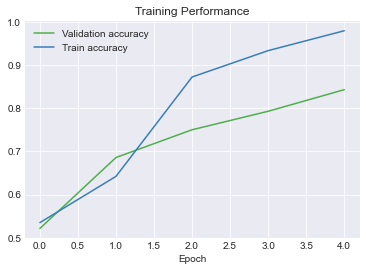

In [17]:
plt.style.use('seaborn-darkgrid')
palette = plt.get_cmap('Set1')

plt.plot(history.history['val_accuracy'], label='Validation accuracy', color = palette(2))
plt.plot(history.history['accuracy'], label='Train accuracy', color = palette(1))
plt.title("Training Performance")
plt.xlabel("Epoch")
plt.legend()
plt.show()

8). Display the test result (accuracy):

In [20]:
score = model.evaluate(X_test,Y_test)
print('Accuracy: {:0.2f}'.format(score[1]))

19/19 [==============================] - 2s 96ms/step - loss: 0.4298 - accuracy: 0.8150
Accuracy: 0.81


In [18]:
Y_pred = model.predict(X_test)
for i in range(len(Y_pred)):
    Y_pred[i]=int(round(float(Y_pred[i]),0))
Y_pred = Y_pred.astype('int32')
Acc=metrics.accuracy_score(Y_test, Y_pred)
Acc 

0.815

<AxesSubplot:xlabel='Predicted', ylabel='Actual'>

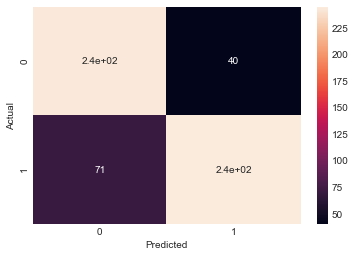

In [19]:
confusion_matrix = pd.crosstab(pd.Series(Y_test.reshape(600)), Y_pred.reshape(600), rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True)